In [1]:
from satpy import Scene
from satpy import find_files_and_readers
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import numpy as np
%matplotlib inline
import cmocean
import cmocean.cm as cmo
%matplotlib inline

In [2]:
fpath = '../SAT_DATA/MODIS_AQUA_NOV_HDF_L1/'
myfiles = find_files_and_readers(base_dir=fpath,
                                 sensor="modis",
                                 reader='modis_l1b')
myfiles

{'modis_l1b': ['../SAT_DATA/MODIS_AQUA_NOV_HDF_L1\\MYD02HKM.A2021322.1935.061.2021323154358.hdf',
  '../SAT_DATA/MODIS_AQUA_NOV_HDF_L1\\MYD03.A2021322.1935.061.2021323151926.hdf']}

There are 4 files in my test. I DO NOT yet know if all are needed. We will have to figure this out.
Pay close attention to the structure of the file names when you download the data:
- MYD03 - This is the georeference file I you definteively need it
- MYD02HKM - I believe this is the file with bands with 250 m resolution (maybe?)
- MYD021KM - bands with 1 km resolution
- MYD02QKM - bands with 2 km resolution (maybe?)

Next pay atention to the date section of the filename:
- A2022061 - The sructure is A+year+day_of_year

Next number I belive is a swat ID, and if you are unluky that your region doesn have a single swat, you will have more than one files of a kind (e.g. MYD021KM.A2022061.1845.061.2022062153735.hdf and MYD021KM.A2022061.0745.061.2022061192910.hdf) there is some blending step you must do, and I havent figured out the detail on this yet
- A2022061.1845.

In [3]:
scn = Scene(filenames=myfiles)

In [4]:
## list available scenes
scn.available_dataset_names()

['1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 'latitude',
 'longitude',
 'satellite_azimuth_angle',
 'satellite_zenith_angle',
 'solar_azimuth_angle',
 'solar_zenith_angle']

In [5]:
# load all scenes cos I'm not sure what Ill need yet
# you DO NOT need to load all bands if you are only ploting true color or only need specific ones
scn.load(scn.available_dataset_names())

In [6]:
##here is all the stuff. 
##Hanna, you should check this to figure out wich bands you need to use for CDOM, and only load those
scn.keys()

[DataID(name='1', wavelength=WavelengthRange(min=0.62, central=0.645, max=0.67, unit='µm'), resolution=500, calibration=<calibration.reflectance>, modifiers=()),
 DataID(name='2', wavelength=WavelengthRange(min=0.841, central=0.8585, max=0.876, unit='µm'), resolution=500, calibration=<calibration.reflectance>, modifiers=()),
 DataID(name='3', wavelength=WavelengthRange(min=0.459, central=0.469, max=0.479, unit='µm'), resolution=500, calibration=<calibration.reflectance>, modifiers=()),
 DataID(name='4', wavelength=WavelengthRange(min=0.545, central=0.555, max=0.565, unit='µm'), resolution=500, calibration=<calibration.reflectance>, modifiers=()),
 DataID(name='5', wavelength=WavelengthRange(min=1.23, central=1.24, max=1.25, unit='µm'), resolution=500, calibration=<calibration.reflectance>, modifiers=()),
 DataID(name='6', wavelength=WavelengthRange(min=1.628, central=1.64, max=1.652, unit='µm'), resolution=500, calibration=<calibration.reflectance>, modifiers=()),
 DataID(name='7', wav

# Resampling to highest res

In [7]:
# resample to the smallest resolution of all available channels
new_scn = scn.resample(resampler='native')

In [8]:
lons, lats = new_scn['1'].attrs['area'].get_lonlats()

C:\Users\12532\AppData\Local\Temp\ipykernel_17308\279725320.py:1: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(lons, lats, new_scn['4'])


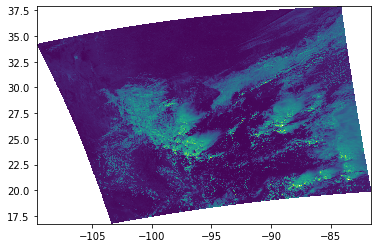

In [10]:
plt.pcolormesh(lons, lats, new_scn['4'])

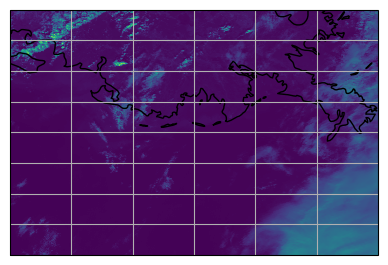

In [11]:
fig = plt.figure(figsize=(6.5, 3.25), dpi=100)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-92, -89, 28, 30])
ax.pcolormesh(lons, lats, new_scn['1'], transform=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines()
# This clearly need some vmin, vmax or figure out a better channel to 

In [12]:
#loading the true color composite
new_scn.load(['true_color'])

In [13]:
from satpy.writers import get_enhanced_image

In [14]:
#creating the RGB
img = get_enhanced_image(new_scn['true_color'])

C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\satpy\modifiers\angles.py:407: RuntimeWarning: invalid value encountered in log
  grad_factor = 1. - np.log(grad_factor + 1) / np.log(2)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


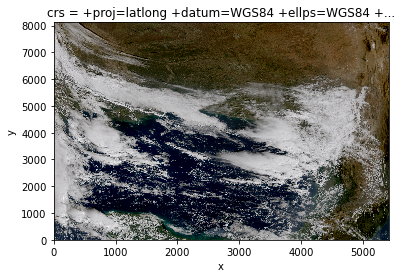

In [15]:
# plot all image
img.data.plot.imshow()
# This image is flipped in x and has bad xy ratio

# Resampling to area 
## (better for RGB as it is more dificult to deal with lat lon)

In [16]:
from pyresample import create_area_def

In [17]:
# Modify the extent:
extent = [-92, 28, -89, 30]
lon_0 = (extent[0]+extent[2])/2
lat_0 = (extent[1]+extent[2])/2

my_area = create_area_def('ROI', {'proj': 'lcc', 'lon_0': lon_0, 'lat_0': lat_0, 'lat_1': 35},
                          width=6000, height=2500,
                          area_extent=extent, units='degrees')
my_area

C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)


Area ID: ROI
Description: ROI
Projection: {'datum': 'WGS84', 'lat_0': '-30.5', 'lat_1': '35', 'lat_2': '0', 'lon_0': '-90.5', 'no_defs': 'None', 'proj': 'lcc', 'type': 'crs', 'units': 'm', 'x_0': '0', 'y_0': '0'}
Number of columns: 6000
Number of rows: 2500
Area extent: (-143037.9489, 6857547.2398, 141312.2181, 7073188.0909)

In [18]:
# Do the actual resampling. Notice is a new object.
# I chose to resaple from the original (scn) and not the resampled (new_scn)
# because it involves interpolation
are_scn = scn.resample(my_area)

In [19]:
# Load true color again, beceuse it was not loaded in the original
are_scn.load(['true_color'])

C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\pyproj\crs\crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._c

In [20]:
# Get the RGB
img2 = get_enhanced_image(are_scn['true_color'])

C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\satpy\modifiers\angles.py:407: RuntimeWarning: invalid value encountered in log
  grad_factor = 1. - np.log(grad_factor + 1) / np.log(2)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


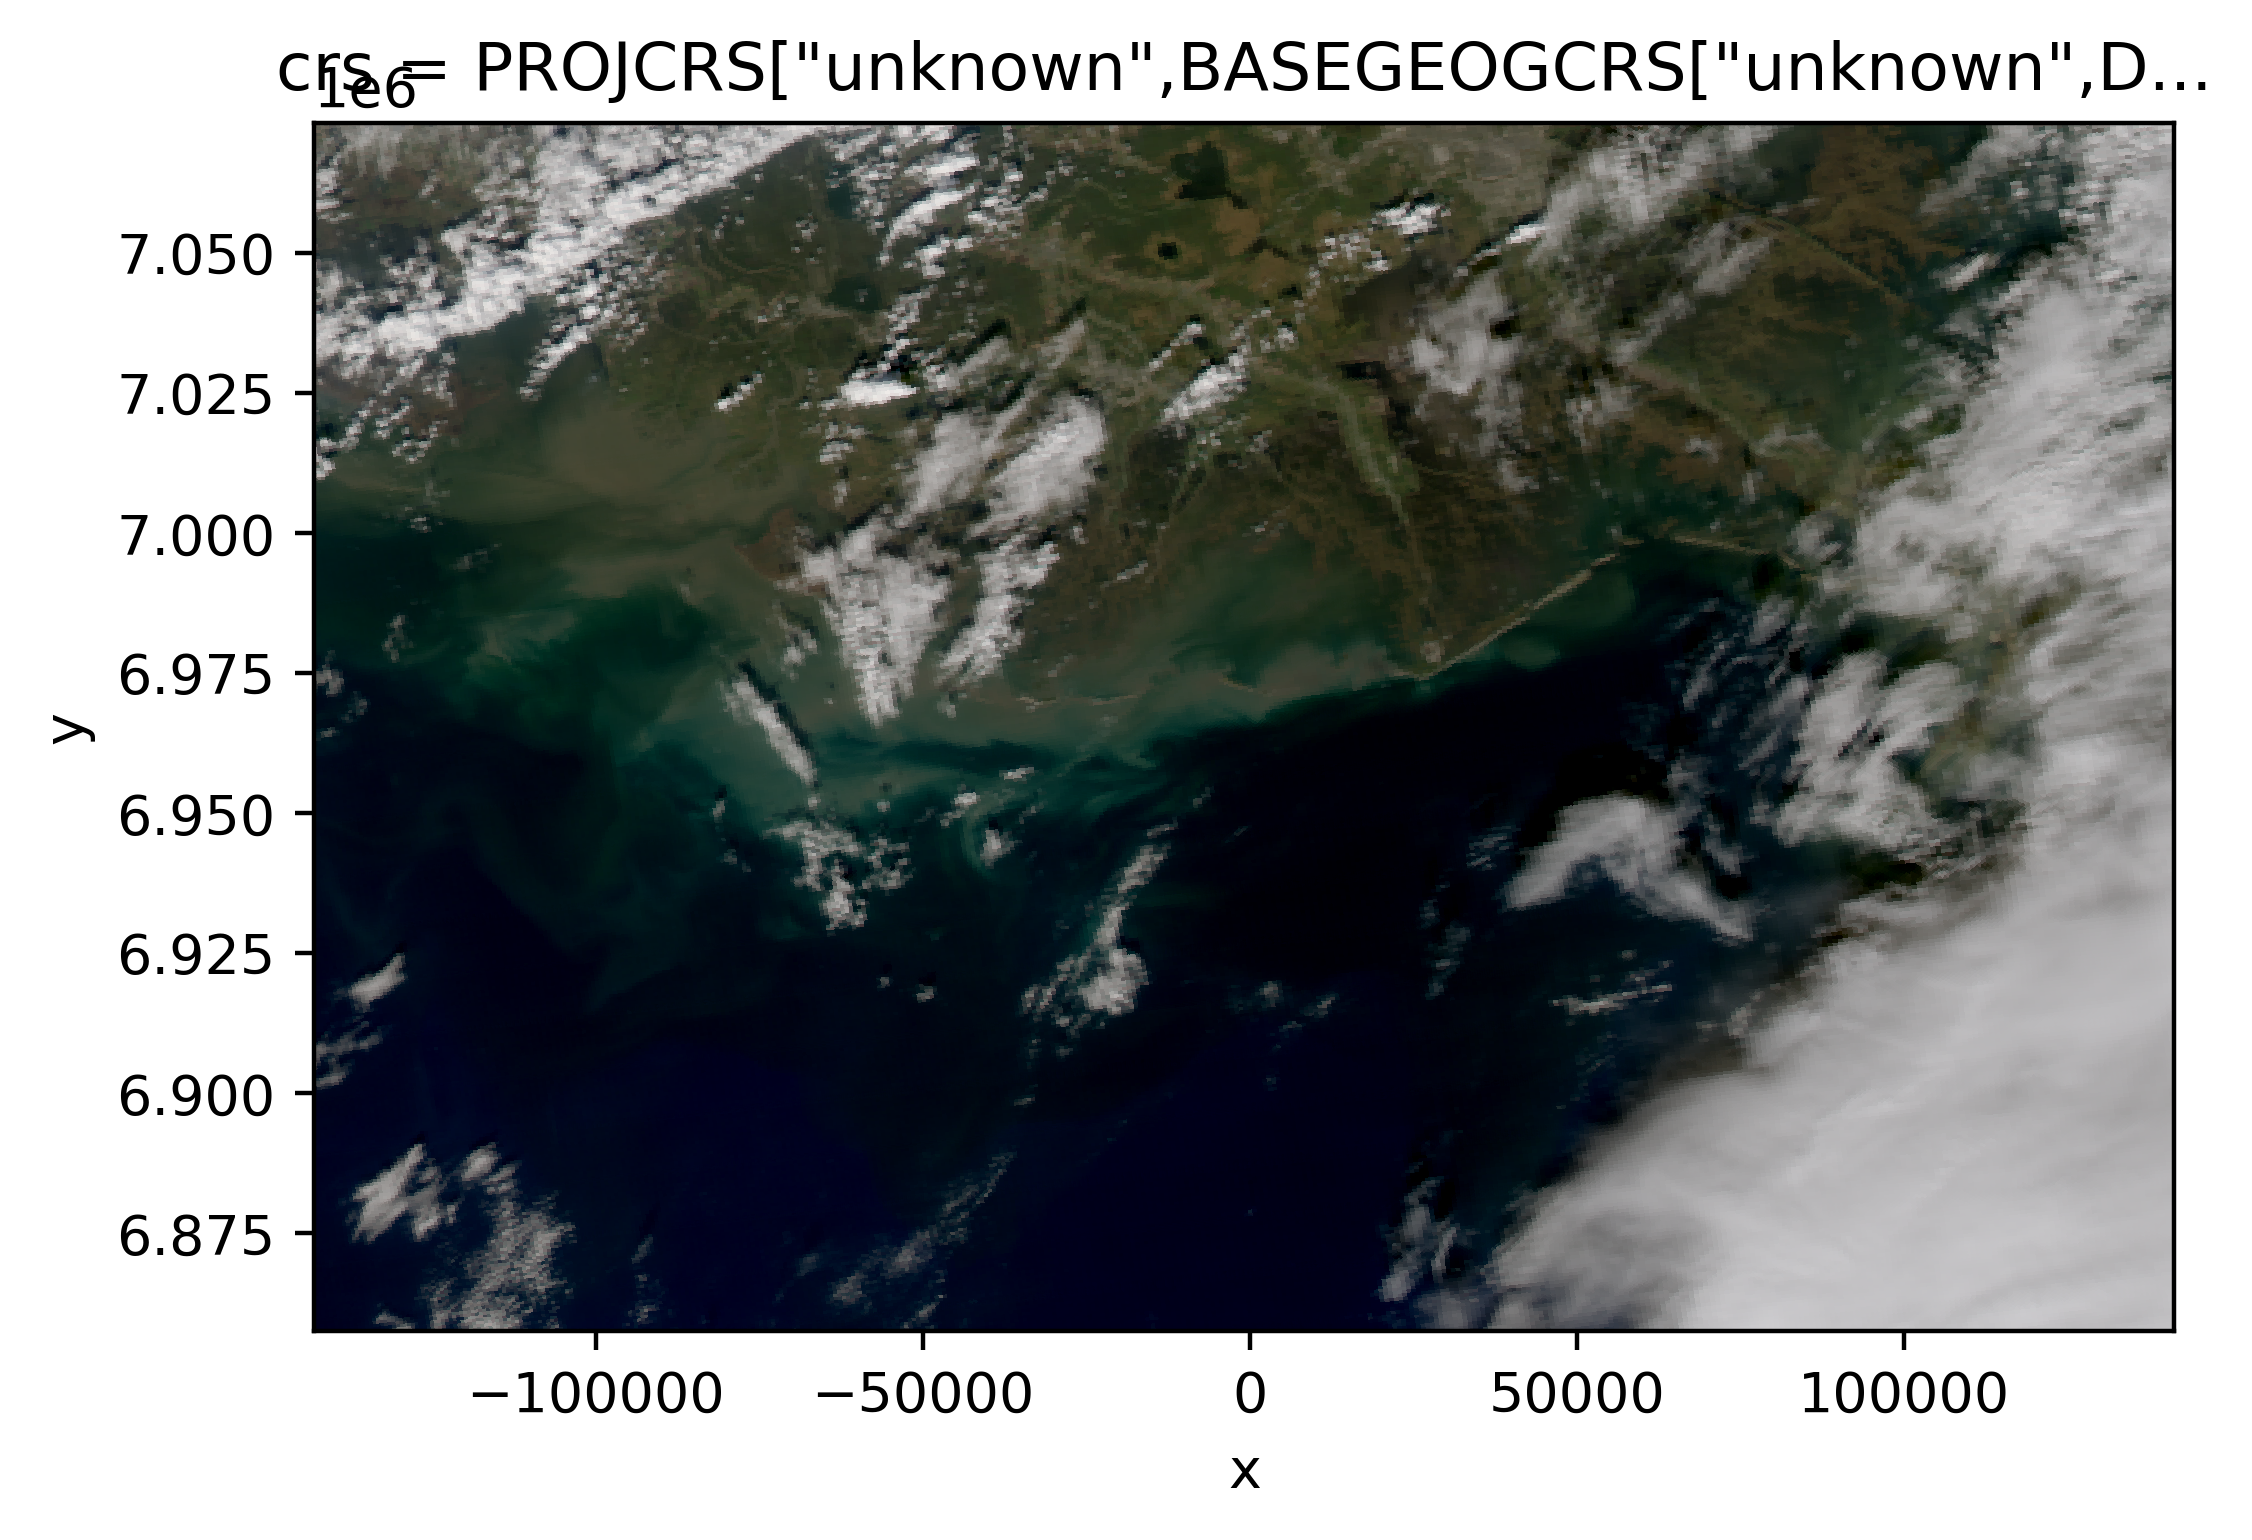

In [21]:
plt.figure(dpi=400)
img2.data.plot.imshow()

C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\satpy\modifiers\angles.py:407: RuntimeWarning: invalid value encountered in log
  grad_factor = 1. - np.log(grad_factor + 1) / np.log(2)


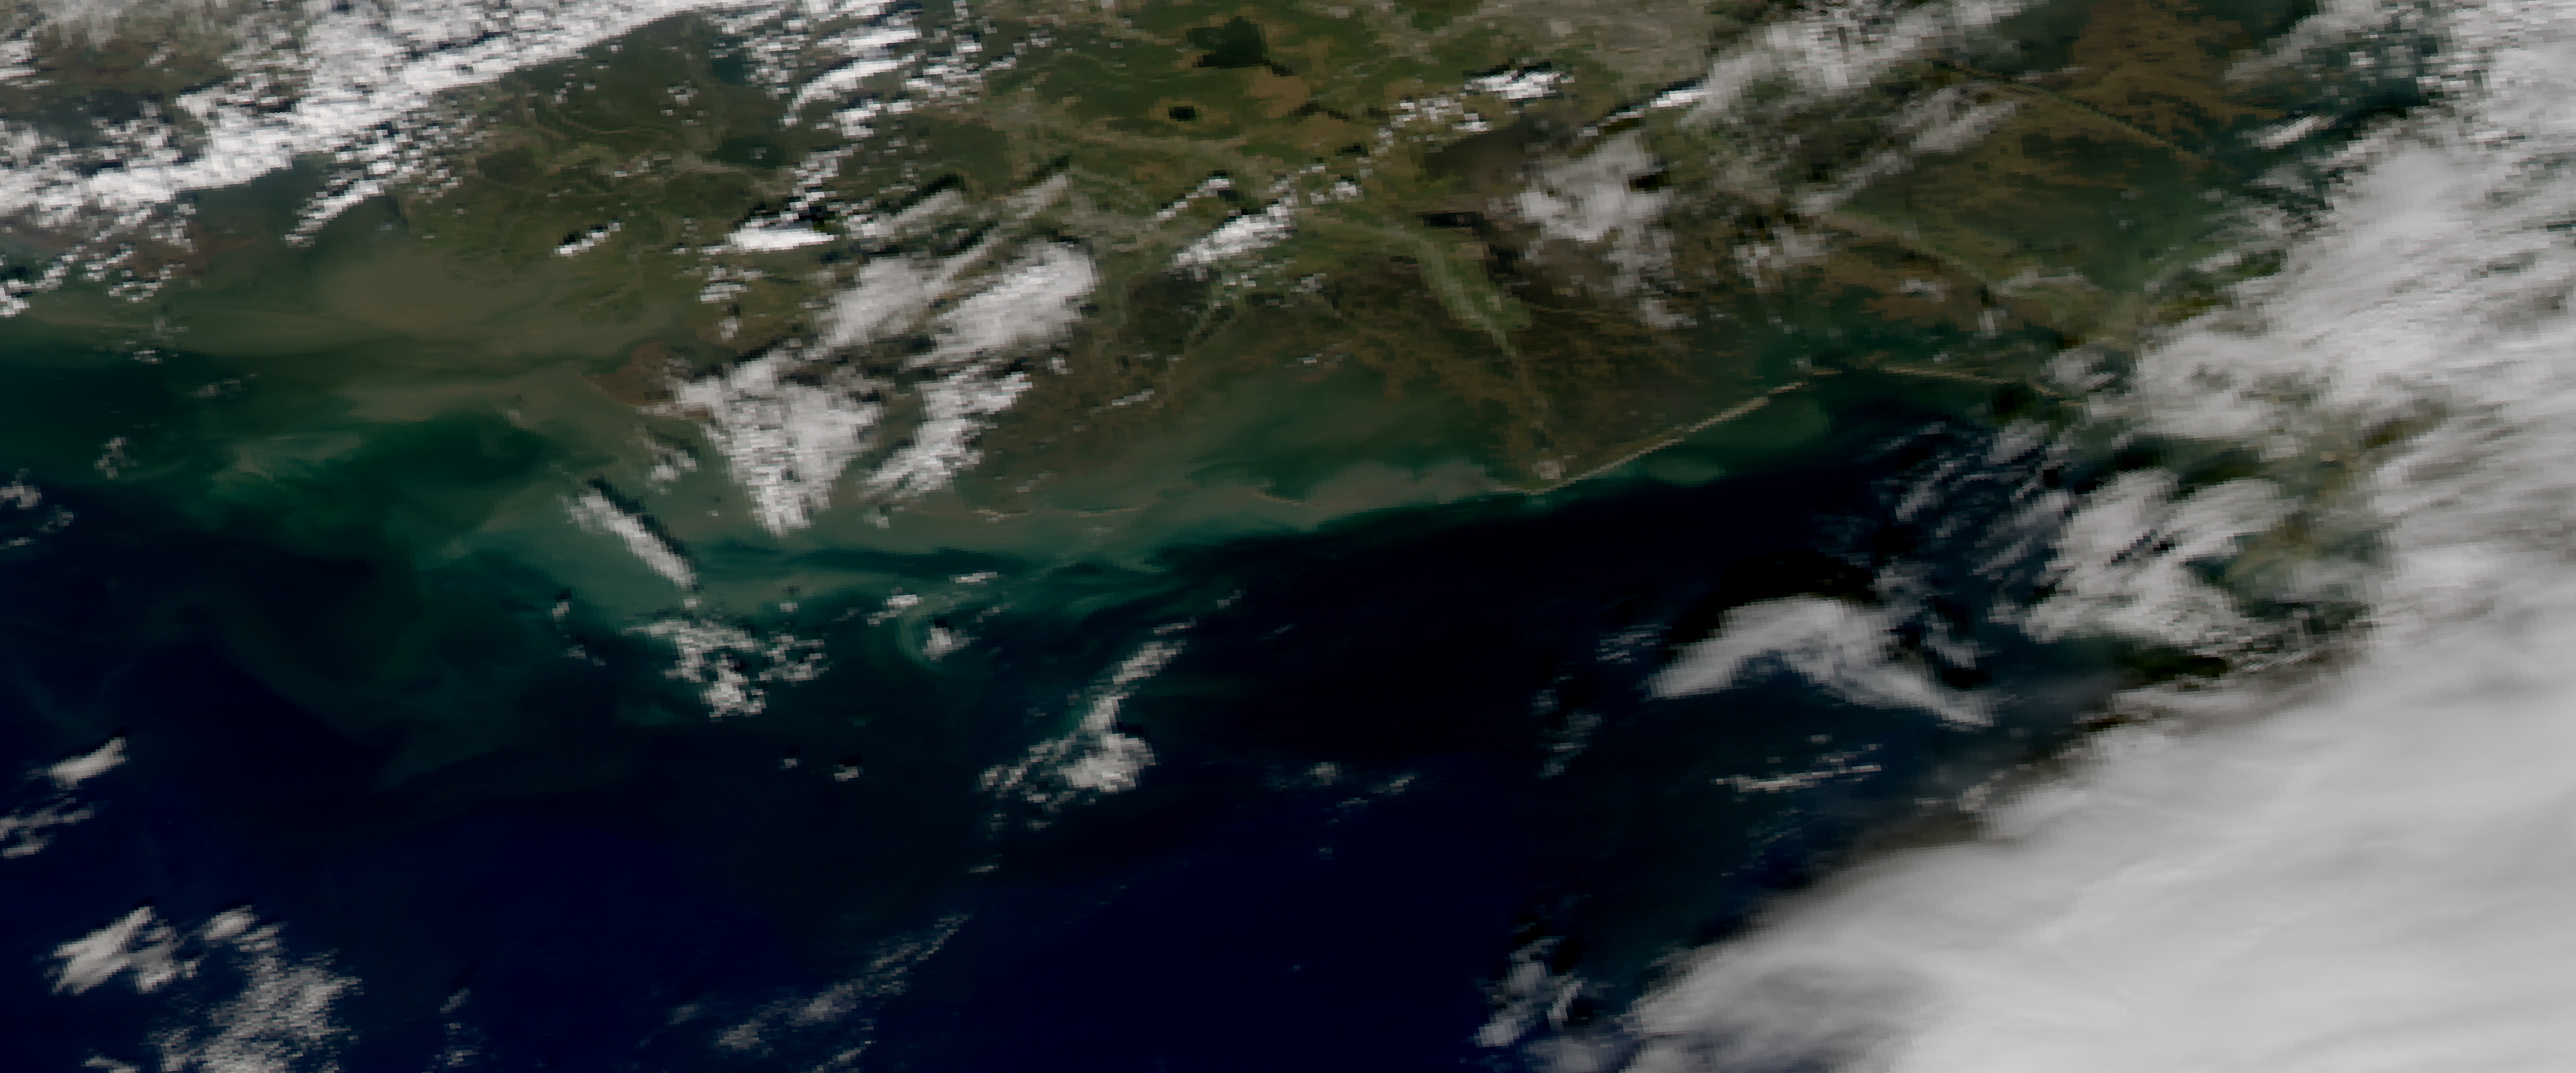

In [22]:
img2

In [23]:
import cartopy.crs as ccrs

In [24]:
lon2, lat2 = are_scn['true_color'].attrs['area'].get_lonlats()

C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\satpy\modifiers\angles.py:407: RuntimeWarning: invalid value encountered in log
  grad_factor = 1. - np.log(grad_factor + 1) / np.log(2)


TypeError: Invalid shape (3, 2500, 6000) for image data

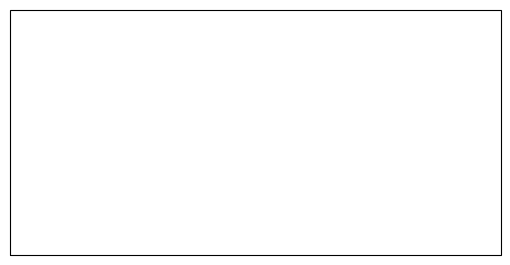

In [25]:
fig = plt.figure(figsize=(6.5, 3.25), dpi=100)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-93, -89, 28.5, 30.5])

ax.imshow(img2.data, 
          #origin='upper', 
          extent=[lon2.min(), lat2.min(), lon2.max(), lat2.max()], transform=ccrs.PlateCarree())
img.data.plot.imshow()
ax.coastlines()
ax.gridlines()